In [39]:
from IPython.display import Image, Markdown, display, HTML

import base64
import pandas as pd
import re

import os, sys
path_to_import = "../src/models/DMCAR"
if path_to_import not in sys.path:
    sys.path.append(path_to_import)
import tomermaid

print(sys.path)

import marshaller
import networkx as nx
import numpy as np

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/tomk/environment/devpy/lib/python3.10/site-packages', '/home/tomk/Documents/Coding/gitHub/digraph/src', '../src/models/DMCAR']


In [2]:
model_df = pd.read_excel("Payments Conceptual Model (DMCAR) v0.2003.xlsx")

In [3]:
popo = marshaller.popo_from_pandas(model_df)

In [4]:
popo.keys()

dict_keys(['domains', 'classes', 'attributes', 'relationships'])

In [5]:
def popo_to_nx(popo):
    g = nx.MultiDiGraph()
    for c in popo['classes']:
        g.add_node(c.name, **{"name" : c.label, "domain" : c.parent_domain.name})

    for r in popo['relationships']:
        g.add_edge(r.from_class.name, r.to_class.name, relationship=r)
    return g

In [6]:
def get_edge_domain_tuple(graph, edge):
    ## requires that the graph nodes be annotated with an attribute called domain.
    fclass = graph.nodes()[edge[0]]
    tclass = graph.nodes()[edge[1]]
    return fclass['domain'], tclass['domain']

In [7]:
def last_common_value(lista, listb):
    for e,i in enumerate(lista):
        if listb[e]!=i:
            return e-1
    return e-1

In [8]:
def nx_domain_hierarchy_from_dmcar_popo(popo):
    domain_hierarchy_g = nx.DiGraph()
    for d in popo['domains']:
        domain_hierarchy_g.add_node("Domain("+d.name+")", **{"name" : d.name})
        
        if isinstance(d.parent_domain, marshaller.Domain):
            domain_hierarchy_g.add_edge("Domain("+d.name+")", "Domain("+d.parent_domain.name+")")
        else:
            domain_hierarchy_g.add_node("Domain(RootDomain)", **{"name" : "RootDomain"})
            domain_hierarchy_g.add_edge("Domain("+d.name+")", "Domain(RootDomain)")
    return domain_hierarchy_g

In [9]:
def nx_domain_subgraph(popo):
    domain_hierarchy_g=nx_domain_hierarchy_from_dmcar_popo(popo)
    domain_class_contents_d={}
    for o in popo['classes']:
        domain_hierarchy_g.add_node(o.name, **{"name" : o.name})
        domain_hierarchy_g.add_edge(o.name, "Domain("+o.parent_domain.name+")")
        if o.parent_domain.name not in domain_class_contents_d.keys():
            domain_class_contents_d[o.parent_domain.name]=[o.name]
        else:
            domain_class_contents_d[o.parent_domain.name].append(o.name)

    # Create the digraph representing the model
    model_g = popo_to_nx(popo)
    # Note that all the relationships need(?) to be assigned to the lowest level in the hierarchy that covers both sides.

    # Interrogate the available graphs to determine the subgroup clusters attributable to both nodes and edges. 
    rel_domain_interaction_d={}
    domain_relationship_contents_d={}
    for s,f,d in model_g.edges(data=True):
        a = (get_edge_domain_tuple(model_g, (s,f)))
        patha=nx.shortest_path(domain_hierarchy_g, s, "Domain(RootDomain)" )[::-1]
        pathb=nx.shortest_path(domain_hierarchy_g, f, "Domain(RootDomain)" )[::-1]
        lca = domain_hierarchy_g.nodes()[patha[last_common_value(patha, pathb)]]['name']
        # Create a dictionary keyed by relationship name whose values reflect the 
        # lowest common ancestor within the domain hierarchy
        rel_domain_interaction_d[d['relationship'].name]=lca
        if lca not in domain_relationship_contents_d.keys():
            domain_relationship_contents_d[lca]=[d['relationship'].name]
        else:
            domain_relationship_contents_d[lca].append(d['relationship'].name)
            

    return domain_relationship_contents_d


        

In [10]:
# Recursive subgraph builder from domain hierarchy starting at root node.
domain_hierarchy_g=nx_domain_hierarchy_from_dmcar_popo(popo)
list(nx.dfs_tree(domain_hierarchy_g.reverse(), "Domain(RootDomain)"))#, reverse=True))

['Domain(RootDomain)',
 'Domain(Payments)',
 'Domain(Accounts)',
 'Domain(Interface)',
 'Domain(Investigation)',
 'Domain(Messaging)',
 'Domain(Party)',
 'Domain(Payment)',
 'Domain(Processing)']

In [11]:
import graphviz

In [12]:
def recursive_domain_walk(hierarchy, graph, domain_node, level=0, content=None):
    if content is None:
        content=""

    content_builder = []
    for class_node, data in graph.nodes(data=True):
        #print(class_node)
        if data['domain'] == hierarchy.nodes()[domain_node]['name'] :
            content_builder.append(class_node)
            
    content=content + (("\t" * level)) + ("\n" + ("\t" * level)).join([c for c in content_builder]) + "\n"

    content_builder = []
    for domain in list(domain_hierarchy_g.reverse().successors(domain_node)):
        content_builder.append( ("\n" + ("\t" * level)) + "subgraph:" + domain + "\n" + recursive_domain_walk(hierarchy, graph, domain, level+1, None))
    content=content + "\n".join([c for c in content_builder])
    return content 
            
        

In [18]:
def recursive_domain_walk_to_graphviz(hierarchy, graph, domain_node, level=0, content=None):
    if content is None:
        #content=graphviz.Digraph(name="Root")
        content=graphviz.Graph(name="Root")

    content_builder = []
    for class_node, data in graph.nodes(data=True):
        if data['domain'] == hierarchy.nodes()[domain_node]['name'] :
            content.node(class_node)
            
    content_builder = []
    for domain in list(domain_hierarchy_g.reverse().successors(domain_node)):
        with content.subgraph(name="cluster_" + hierarchy.nodes()[domain]['name'] ) as sg:
            recursive_domain_walk_to_graphviz(hierarchy, graph, domain, level+1, sg)

    domain = hierarchy.nodes()[domain_node]['name'] 
    rels_by_domain = nx_domain_subgraph(popo)
    for r in rels_by_domain.get(domain, []):
        for rel_from, rel_to, data in graph.edges(data=True):
            rel = data['relationship']
            
            if rel.name == r:
                print(domain, rel.name)
                content.edge(rel_from, rel_to, label=rel.name)
    
    return content 
            
        

In [19]:
g = popo_to_nx(popo)

In [20]:
c = recursive_domain_walk_to_graphviz(domain_hierarchy_g, g, 'Domain(RootDomain)', content=None)

Accounts hasHolder
Accounts hostsMandate
Accounts hostsSO
Accounts isServicedBy
Accounts appliedTo
Interface IsSubClassOf(7)
Interface usesMedia
Messaging Function
Messaging hasType
Party IsSubClassOf(6)
Party IsSubClassOf(3)
Party IsSubClassOf(2)
Party IsSubClassOf(1)
Payment PartOfGroup
Payment applied
Payment appliedFX
Payment associatedObligation
Payment hasPartyRole
Payment references
Payment parentBlock
Payments IsSubClassOf(4)
Payments IsSubClassOf(5)
Payments authorisedParty
Payments memberOfMedia
Payments InstructedIn
Payments ReferencedIn
Payments bookedEntries
Payments inboundInterface
Payments initiatingInterface
Payments outboundInterface
Payments referencesMandate
Payments referencesSO
Payments InstructedIn(2)
Payments InstructedIn(3)
Payments ReferencedPayment
Payments ReferencedPaymentGroup
Payments TransmittedOver
Payments assignedRole
Payments associatedParty


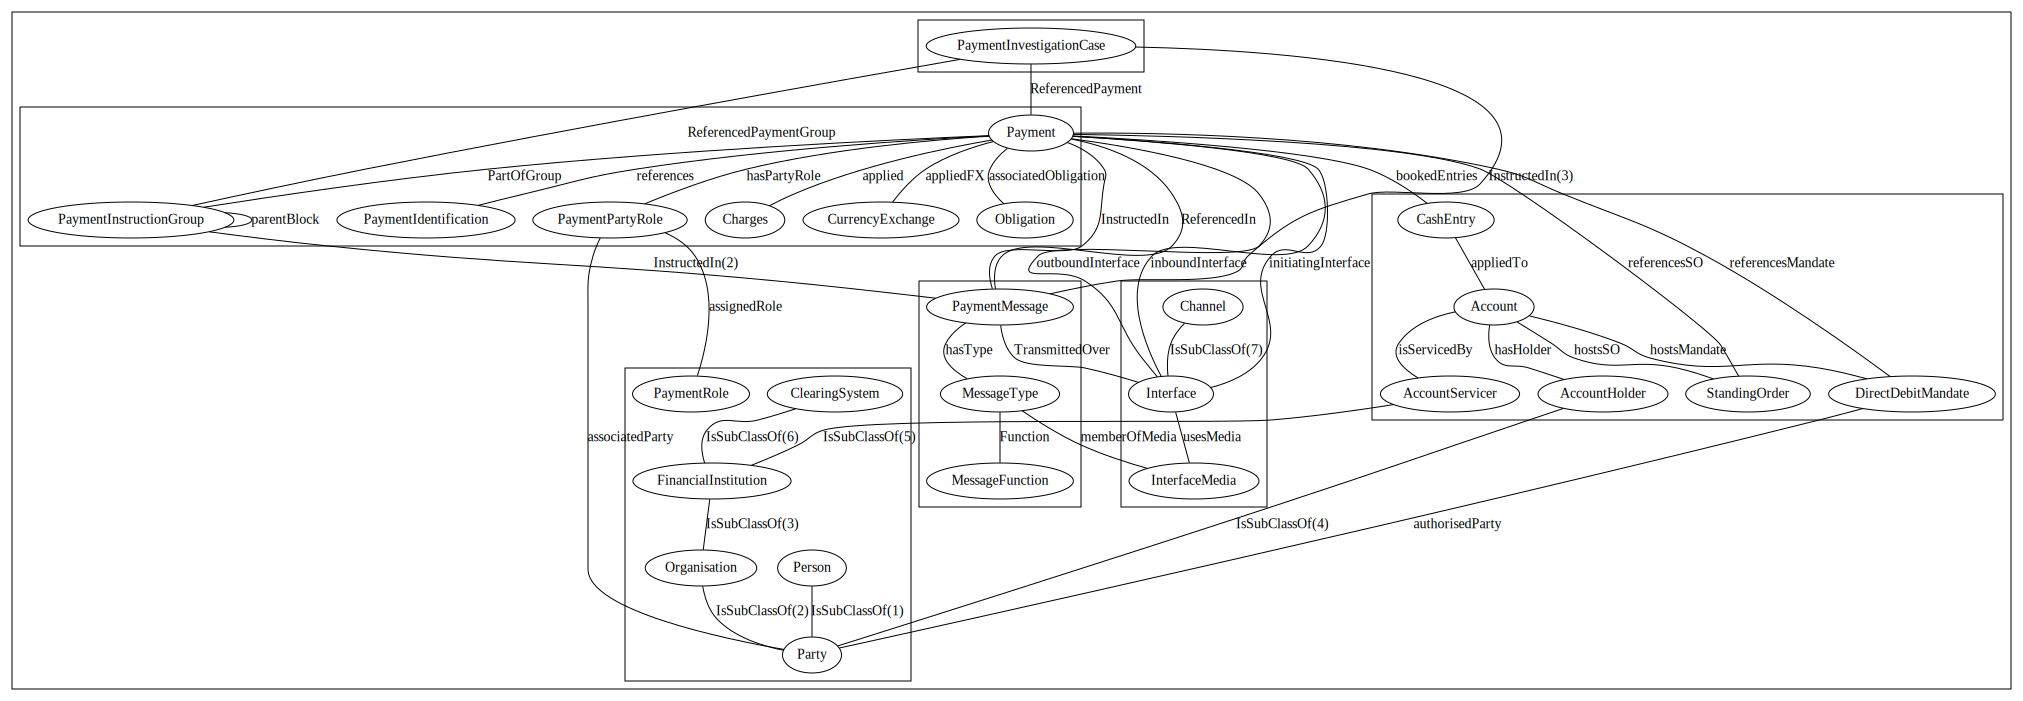

In [21]:
display(c)

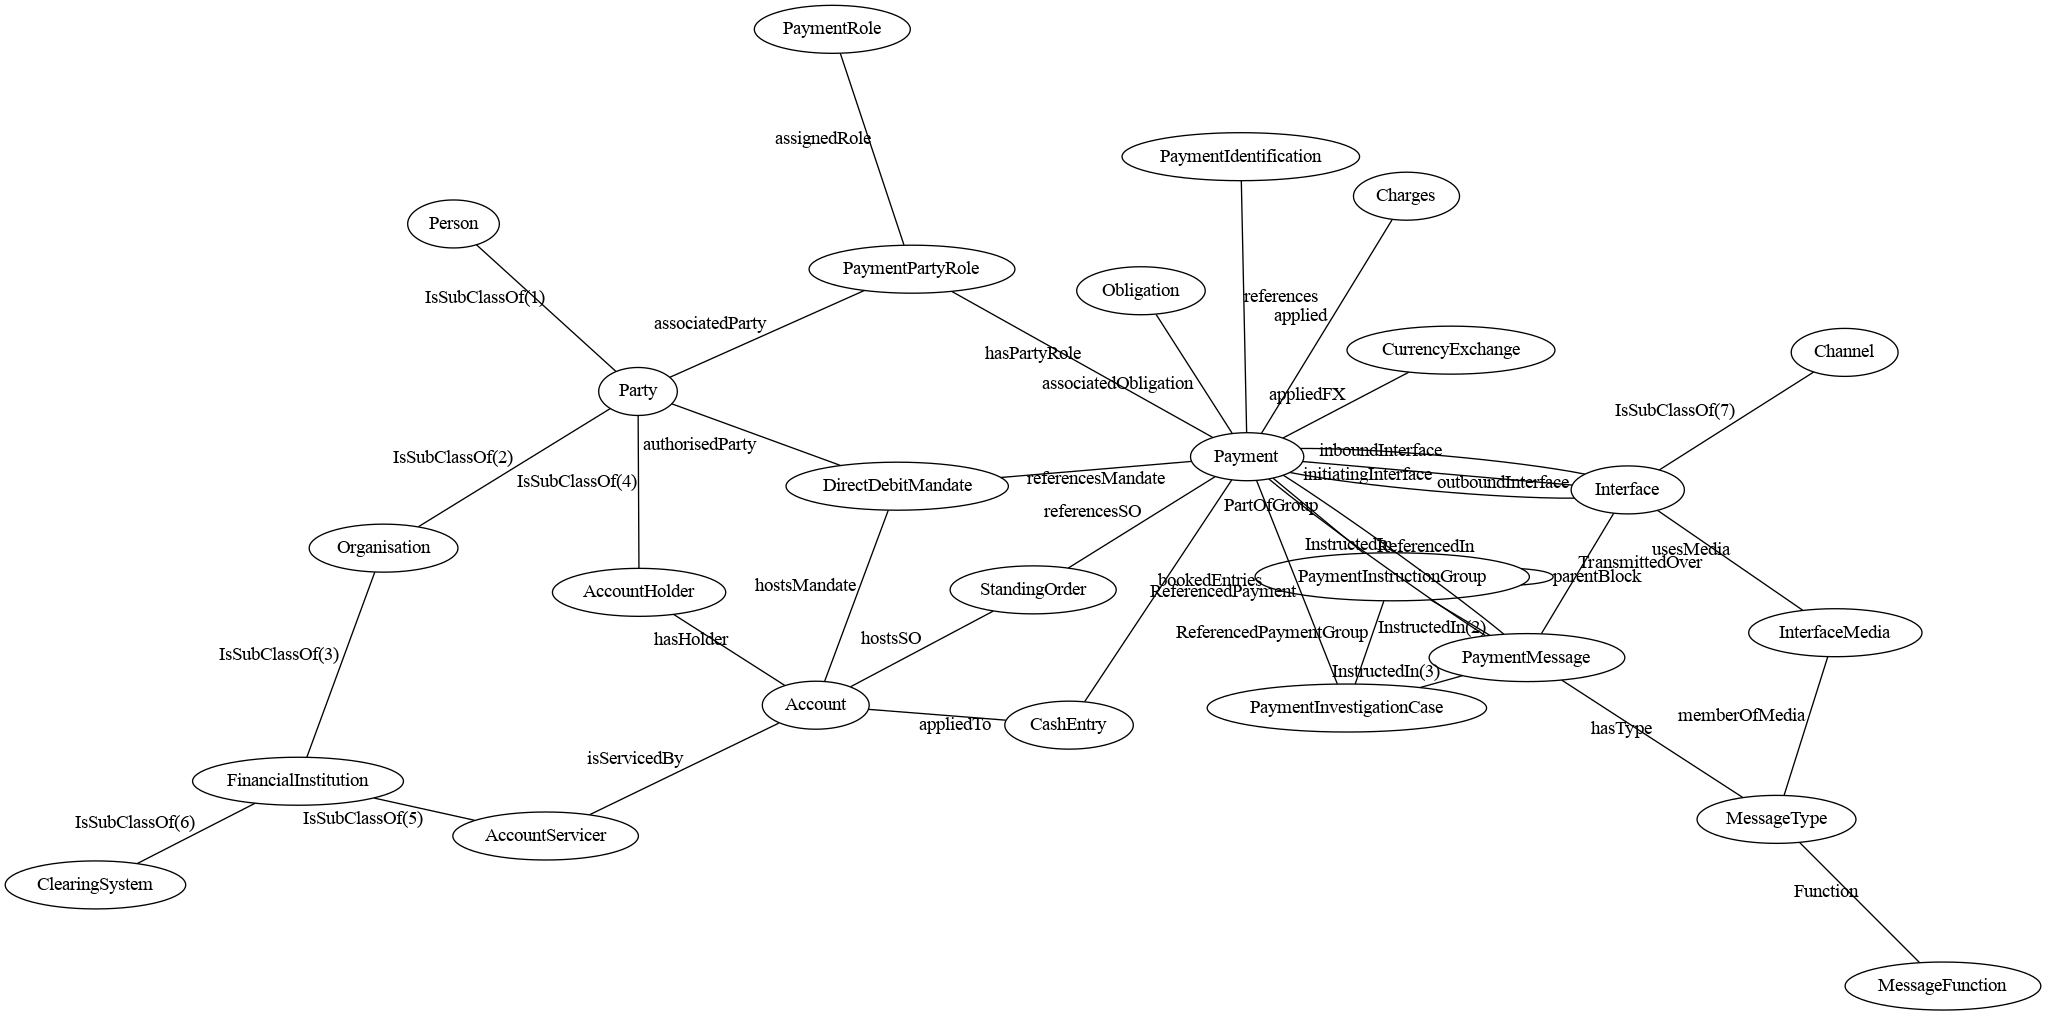

In [42]:
display(Image(c.pipe(engine="sfdp", format="png")))

In [ ]:
for domain_name in list(nx.bfs_tree(domain_hierarchy_g.reverse(), "Domain(RootDomain)")):
    print(domain_name, domain_hierarchy_g.nodes()[domain_name]['name'] )
    print( list(domain_hierarchy_g.reverse().successors(domain_name)) )
    print( )

In [ ]:
rels_by_domain

In [ ]:
g = popo_to_nx(popo)
print(g.nodes())
rel_domain_interaction_d={}
for s,f,d in g.edges(data=True):
    a = (get_edge_domain_tuple(g, (s,f)))
    patha=nx.shortest_path(dg, s, "Domain(RootDomain)" )[::-1]
    pathb=nx.shortest_path(dg, f, "Domain(RootDomain)" )[::-1]
    lca = dg.nodes()[patha[last_common_value(patha, pathb)]]['name']
    # Create a dictionary keyed by relationship name whose values reflect the 
    # lowest common ancestor within the domain hierarchy
    rel_domain_interaction_d[d['relationship'].name]=lca


rel_domain_interaction_d
    

In [ ]:
dg = nx_domain_subgraph(popo)
pos = nx.nx_agraph.graphviz_layout(dg)
labels=nx.get_node_attributes(dg, "name")
nx.draw(dg, pos=pos, labels=labels)

In [ ]:
popo['relationships'][0].from_class.name

In [ ]:
domain_cols = {'Accounts' : "orange", 
 'Interface' : "lightgreen", 
 'Investigation' : "purple", 
 'Messaging' : "lightblue", 
 'Party' : "pink", 
 'Payment' : "yellow"}

In [ ]:
set(nx.get_node_attributes(g, "domain").values())

In [ ]:
from matplotlib import colors
orange_rgb = colors.hex2color(colors.cnames['orange'])
orange_rgb
colors.cnames['orange']

In [ ]:
pos = nx.nx_agraph.graphviz_layout(g)
labels=nx.get_node_attributes(g, "name")
#colors=np.array([colors.cnames[domain_cols[d]] for n,d in nx.get_node_attributes(g, "domain").items()])
colors=[domain_cols[d] for n,d in nx.get_node_attributes(g, "domain").items()]
nx.draw(g, pos=pos, labels=labels, node_color=colors)

In [ ]:
def create_searchable_list(list_of_objects):
    return_d = {}
    for o in list_of_objects:
        return_d[o.name]=o
    return return_d

In [ ]:
#create_searchable_list(popo['classes'], None)

In [ ]:
set(nx.get_node_attributes(g, "domain").values())